In [1]:
import os, glob, re, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

In [2]:
dir_path = "data/archive/Dataset_BUSI_with_GT/"
IMAGE_SHAPE = (224, 224)

In [3]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation((-0.05, 0.05)),
])
# create prepare_image method
# used to preprocess the image for efficientNet model
def prepare_image(file1, label1, file2 = None, label2 = None, beta = False, augment = True):

    img1 = image.load_img(file1, target_size=IMAGE_SHAPE)
    if augment:
        img1 = data_augmentation(img1)
    img_array = image.img_to_array(img1)
    label = label1

    if file2:

        img2 = image.load_img(file2, target_size=IMAGE_SHAPE)
        if augment:
            img2 = data_augmentation(img2)
        img_array2 = image.img_to_array(img2)

        alpa = 0
        if beta:
            alpha = np.random.beta(0.2, 0.2, 1)
        else:
            alpha = random.random()

        #print(f"Alpha = {alpha}")

        img_array = (alpha * img_array) + ((1-alpha) * img_array2)
        label     = (alpha * label1) +    ((1-alpha) * label2)

    return tf.keras.applications.efficientnet.preprocess_input (img_array), label

In [4]:
directories = os.listdir(dir_path) # read the folders

files = [] # save all images for each folder
labels = [] # set for each image the name of it

# read files for each directory
for folder in directories:
    
    fileList = glob.glob(f'{dir_path}/{folder}/*')
    labels.extend([folder for _ in fileList])
    files.extend(fileList)

len(files), len(labels)


(1578, 1578)

In [5]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{'benign': 891, 'malignant': 421, 'normal': 266}


In [6]:
from keras import utils
from sklearn.preprocessing import LabelEncoder
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = utils.to_categorical(encoded_Y,dtype ="uint8", num_classes = 3)

labels = np.array(dummy_y)

print(f"Classes are {encoder.classes_}")

Classes are ['benign' 'malignant' 'normal']


In [7]:
# create two lists to hold only non-mask images and label for each one
selected_files = []
selected_labels = []

for file, label in zip(files, labels):
    if 'mask' not in file:
        selected_files.append(file)
        selected_labels.append(label)

len(selected_files), len(selected_labels)

(780, 780)

Label is [0.25035219 0.74964781 0.        ]


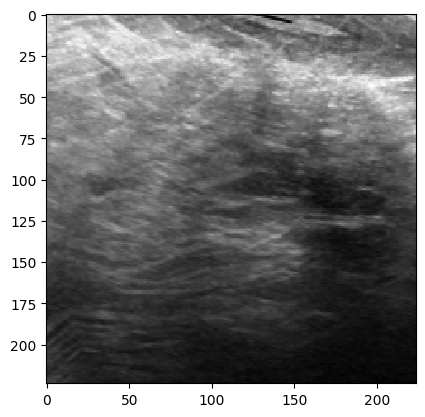

In [8]:
#TEST MIXUP

test_image, label = prepare_image(selected_files[70], selected_labels[70],  selected_files[502], selected_labels[502], False)
test_image = tf.keras.utils.array_to_img(test_image)

print(f"Label is {label}")

plt.imshow(test_image, interpolation='nearest')

In [9]:
x_train, x_test, y_train, y_test = train_test_split(selected_files, selected_labels, test_size=.10)

# x_train.shape, x_test.shape, y_train.shape, y_test.shape 

In [10]:
def get_balance_iters(label):
    if label[0] == 1:
        return 1
    elif label[1] == 1:
        return 2
    else:
        return 3

In [11]:
import random

# the dictionary holds list of images and for each one has its target/label
images = {
    'image_train': [], 
    'target_train': [],
    'image_test': [], 
    'target_test': [],
}

print('Preparing the images...')

MIXUP = True
ITERS = 3
BETA = False
BALANCE = True
AUG = True

for file, label in zip(x_train, y_train):

    if BALANCE == True:
        balance_iters = get_balance_iters(label)
    else:
        balance_iters = 1

    for value in range(balance_iters):

        if MIXUP == False:
            new_file, new_label = prepare_image(file, label, beta = BETA, augment = AUG)
            images['image_train'].append(new_file)
            images['target_train'].append(new_label)

        elif MIXUP == True:
            for i in range(ITERS):
                random_file_i = random.randint(0,len(selected_files)-1)
                new_file, new_label = prepare_image(file, label, selected_files[random_file_i],selected_labels[random_file_i], beta = BETA, augment = AUG)
                images['image_train'].append(new_file)
                images['target_train'].append(new_label)


for file, label in zip(x_test, y_test):

    if BALANCE == True:
        balance_iters = get_balance_iters(label)
    else:
        balance_iters = 1

    for value in range(balance_iters):

        new_file, new_label = prepare_image(file, label, beta = BETA, augment = AUG)
        images['image_test'].append(new_file)
        images['target_test'].append(new_label)



print('Finished.')

Preparing the images...
Finished.


In [12]:
count0 = 0
count1 = 0
count2 = 0
for label in images['target_train']:
    if label[0] == 1:
        count0 += 1
    elif label[1] == 1:
        count1 += 1
    else:
        count2 += 1

print(f"benign: {count0}, malignant: {count1}, normal: {count2}")

benign: 665, malignant: 290, normal: 2447


In [13]:
# convert lists to arrays 
x_train = np.array(images['image_train'])
y_train = np.array(images['target_train'])
x_test = np.array(images['image_test'])
y_test = np.array(images['target_test'])

In [14]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((3402, 224, 224, 3), (122, 224, 224, 3), (3402, 3), (122, 3))

In [15]:
# The code is creating a ResNet152V2 model with pre-trained weights from the ImageNet dataset. 
# The base model is frozen, meaning its weights will not be updated during training. 
# The code then appends additional layers on top of the base model for transfer learning.

from tensorflow.keras.applications import resnet_v2
base_model = resnet_v2.ResNet152V2(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMAGE_SHAPE, 3),
    classes=3)

# Freeze the base_model
base_model.trainable = False

# append my own layers on the top of the model for Transfer Learning
x = base_model.output

# 1st conv block
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 2nd conv block
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 1st FC layer
x = layers.Flatten()(x) 
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# 2nd FC layer
x = layers.Dense(32, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.2)(x)

x = layers.Dense(3, 'softmax')(x)

incept_model = keras.models.Model(inputs = base_model.input, outputs = x)

# compile the model
incept_model.compile(optimizer=optimizers.RMSprop(.001), loss = losses.categorical_crossentropy, metrics= [metrics.CategoricalAccuracy()])

# incept_model.summary()

In [16]:
EPOCHS = 1 #60
# Trains and returns incept_model. fit ( x_train y_train )
earlyStop = keras.callbacks.EarlyStopping(patience=60) 
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True) 

with tf.device('/gpu:0'):
    history = incept_model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS, validation_data=(x_test, y_test), callbacks=[earlyStop, best_model]) 

107/107 [==============================] - ETA: 0s - loss: 1.2233 - categorical_accuracy: 0.4221

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 244s 2s/step - loss: 1.2233 - categorical_accuracy: 0.4221 - val_loss: 1.2257 - val_categorical_accuracy: 0.3607


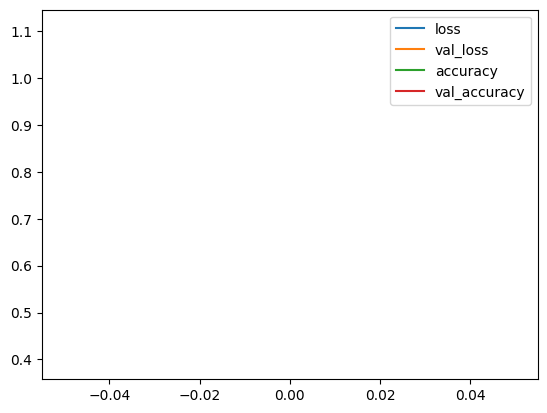

In [25]:
hist = history.history

plt.plot(hist['loss'], label=  'loss')
plt.plot(hist['val_loss'], label = 'val_loss')
plt.plot(hist['categorical_accuracy'], label='accuracy')
plt.plot(hist['val_categorical_accuracy'], label='val_accuracy')
plt.legend()

In [18]:
incept_model.evaluate(x=x_test, y = y_test, batch_size=32, verbose=1)

4/4 [==============================] - 8s 2s/step - loss: 1.2257 - categorical_accuracy: 0.3607


[1.2256731986999512, 0.3606557250022888]

In [19]:
# open train the last 100 layers
for layer in incept_model.layers[720:]:
    layer.trainable = True
    
# compile the model with new optimizer and lr=.0001
incept_model.compile(optimizer=optimizers.RMSprop(.0001), loss = losses.categorical_crossentropy, metrics=[metrics.CategoricalAccuracy()])

# incept_model.summary()

In [20]:
earlyStop = keras.callbacks.EarlyStopping(patience=60) 
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model_2.h5', save_best_only=True) 

# load the best weights
# incept_model.set_weights(best_weights)

with tf.device('/gpu:0'):
    history = incept_model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS, validation_data=(x_test, y_test), callbacks=[earlyStop, best_model]) 

107/107 [==============================] - 241s 2s/step - loss: 1.0315 - categorical_accuracy: 0.5347 - val_loss: 1.1100 - val_categorical_accuracy: 0.3934


In [21]:
x = incept_model.evaluate(x=x_test, y = y_test, batch_size=32, verbose=1)

4/4 [==============================] - 8s 2s/step - loss: 1.1100 - categorical_accuracy: 0.3934


In [22]:
# used to predict the model and visualize the orignal image with title of true and pred values
def predict_image(img_path, label):
    img1 = prepare_image(img_path) # preprocess the image
    res = incept_model.predict(np.expand_dims(img1, axis = 0)) # predict the image
    pred = classes[np.argmax(res)]

    return pred, label

In [23]:
pred_array = []

for i in range(len(x_test)):
    res = incept_model.predict(np.expand_dims(x_test[i], axis = 0))
    pred = [0,1,2][np.argmax(res)]
    
    pred_array.append(pred)

print(pred_array)

1/1 [==============================] - 0s 145ms/step
[0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 1, 0, 0, 0, 0, 0, 1, 0]


[1 0 0]
[1 0 0]
[0 0 1]
[0 0 1]
[0 0 1]
[1 0 0]
[0 1 0]
[0 1 0]
[1 0 0]
[0 0 1]
[0 0 1]
[0 0 1]
[0 1 0]
[0 1 0]
[1 0 0]
[1 0 0]
[1 0 0]
[1 0 0]
[1 0 0]
[1 0 0]
[1 0 0]
[0 1 0]
[0 1 0]
[0 1 0]
[0 1 0]
[1 0 0]
[1 0 0]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[1 0 0]
[1 0 0]
[1 0 0]
[1 0 0]
[1 0 0]
[1 0 0]
[1 0 0]
[1 0 0]
[0 0 1]
[0 0 1]
[0 0 1]
[1 0 0]
[0 1 0]
[0 1 0]
[0 0 1]
[0 0 1]
[0 0 1]
[0 1 0]
[0 1 0]
[1 0 0]
[0 1 0]
[0 1 0]
[1 0 0]
[0 0 1]
[0 0 1]
[0 0 1]
[1 0 0]
[0 1 0]
[0 1 0]
[1 0 0]
[0 1 0]
[0 1 0]
[0 1 0]
[0 1 0]
[0 0 1]
[0 0 1]
[0 0 1]
[1 0 0]
[1 0 0]
[1 0 0]
[0 0 1]
[0 0 1]
[0 0 1]
[1 0 0]
[0 1 0]
[0 1 0]
[1 0 0]
[1 0 0]
[1 0 0]
[1 0 0]
[1 0 0]
[0 0 1]
[0 0 1]
[0 0 1]
[0 1 0]
[0 1 0]
[1 0 0]
[0 1 0]
[0 1 0]
[0 1 0]
[0 1 0]
[0 0 1]
[0 0 1]
[0 0 1]
[1 0 0]
[0 1 0]
[0 1 0]
[1 0 0]
[0 0 1]
[0 0 1]
[0 0 1]
[0 1 0]
[0 1 0]
[1 0 0]
[1 0 0]
[1 0 0]
[1 0 0]
[1 0 0]
[1 0 0]
[0 0 1]
[0 0 1]
[0 0 1]
[0 1 0]
[0 1 0]
[1 0 0]
[1 0 0]
[0 1 0]
[0 1 0]
[1 0 0]


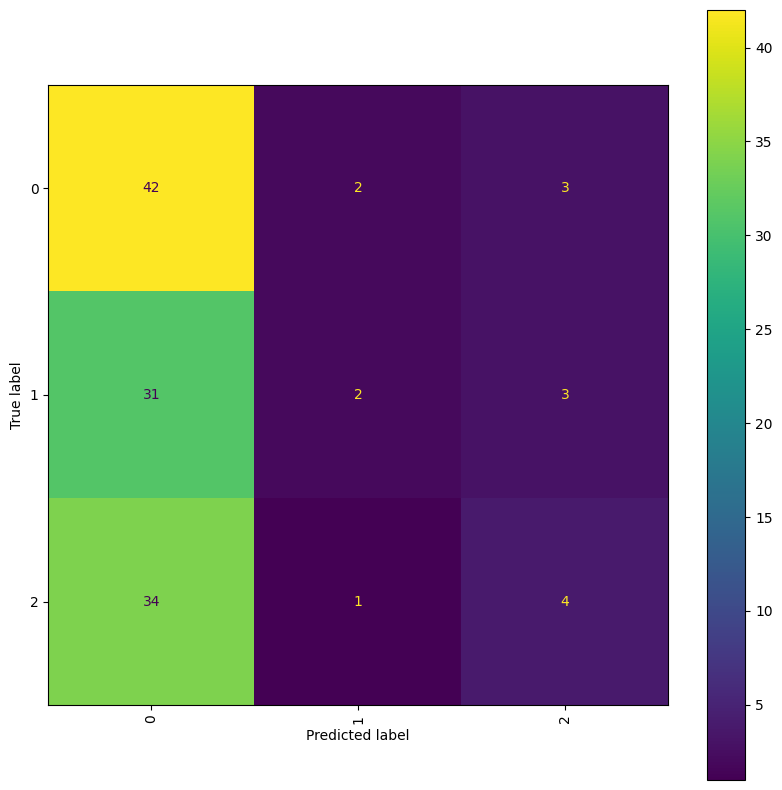

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

y_actual = []
for pred in y_test:
    
    if pred[0] == 1:
        y_actual.append(0)
    if pred[1] == 1:
        y_actual.append(1)
    if pred[2] == 1:
        y_actual.append(2)


fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_actual,
    pred_array,
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)